![](./resources/Custom_croptype_map.png)

### Content

- [Introduction](###-Introduction)
- [How to run this notebook?](###-How-to-run-this-notebook?)
- [Before you start](###-Before-you-start)
- [1. Gather and prepare your training data](###-1.-Gather-and-prepare-your-training-data)
- [2. Prepare training features](###-2.-Prepare-training-features)
- [3. Train custom classification model](###-3.-Train-custom-classification-model)
- [4. Deploy your custom model](###-4.-Deploy-your-custom-model)
- [5. Generate your custom crop type map](###-5.-Generate-your-custom-crop-type-map)

### Introduction

This notebook guides you through the process of training a custom crop type classification model for your area, season and crop types of interest.

For training the model, you can use a combination of:
- publicly available reference data harmonized by the WorldCereal consortium;
- your own private reference data.

<div class="alert alert-block alert-warning">
In case you would like to use private reference data to train your model, make sure to first complete the workflow as outlined in our separate notebook <b>worldcereal_private_extractions.ipynb</b>.
</div>

After model training, we deploy your custom model to the cloud, from where it can be accessed by OpenEO, allowing you to apply your model on your area and season of interest and generate your custom crop type map.

### How to run this notebook?

#### Option 1: Run on Terrascope

You can use a preconfigured environment on [**Terrascope**](https://terrascope.be/en) to run the workflows in a Jupyter notebook environment. Just register as a new user on Terrascope or use one of the supported EGI eduGAIN login methods to get started.

Once you have a Terrascope account, you can run this notebook by clicking the button shown below.

<div class="alert alert-block alert-warning">When you click the button, you will be prompted with "Server Options".<br>
Make sure to select the "Worldcereal" image here. Did you choose "Terrascope" by accident?<br>
Then go to File > Hub Control Panel > Stop my server, and click the link below once again.</div>


<a href="https://notebooks.terrascope.be/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FWorldCereal%2Fworldcereal-classification&urlpath=lab%2Ftree%2Fworldcereal-classification%2Fnotebooks%2Fworldcereal_custom_croptype.ipynb&branch=main"><img src="https://img.shields.io/badge/Generate%20custom%20crop%20type%20map-Terrascope-brightgreen" alt="Generate custom crop type map" valign="middle"></a>


<div class="alert alert-block alert-warning">
<b>WARNING:</b> <br>
Every time you click the above link, the latest version of the notebook will be fetched, potentially leading to conflicts with changes you have made yourself.<br>
To avoid such code conflicts, we recommend you to make a copy of the notebook and make changes only in your copied version.
</div>


#### Option 2: Install Locally

If you prefer to install the package locally, you can create the WorldCereal environment using **Conda** or **pip**.

First clone the repository:
```bash
git clone https://github.com/WorldCereal/worldcereal-classification.git
cd worldcereal-classification
```
Next, install the package locally:
- for Conda: `conda env create -f environment.yml`
- for Pip: `pip install .[train,notebooks]`

### Before you start

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/).<br>
This is free of charge and will grant you a number of free openEO processing credits to continue this demo.

### 1. Gather and prepare your training data

Note:
In case you would like to explore the availability of publicly available reference data for your region of interest, you can:

- use the WorldCereal Reference Data Module user interface, available [here](https://rdm.esa-worldcereal.org/). More explanation can be found [here](https://worldcereal.github.io/worldcereal-documentation/rdm/explore.html#explore-data-through-our-user-interface).
- use our dedicated notebook [worldcereal_RDM_demo.ipynb](https://github.com/WorldCereal/worldcereal-classification/blob/main/notebooks/worldcereal_RDM_demo.ipynb).

**Step 1: Select your area of interest (AOI)**

Provide a bounding box specifying the region in which you would like to look for available reference data.<br>

When running the code snippet below, an interactive map will be visualized.<br>
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.<br>
The widget will automatically store the coordinates of the last rectangle you drew on the map.<br>

Alternatively, you can also upload a vector file (either zipped shapefile or GeoPackage) delineating<br>
your area of interest. In case your vector file contains multiple polygons or points, the total bounds<br>
will be automatically computed and serve as your AOI. Files containing only a single point are not allowed.

In [ ]:
from worldcereal.utils.map import ui_map

map = ui_map()

**Step 2: Get all available reference data**

Now we query both public and private extractions and retrieve the relevant samples based on your defined area of interest.

<div class="alert alert-block alert-info">
<b>Note on the use of private data</b><br>
In case you would like to include your private extractions, make sure to specify the private_extractions_path in the cell below, where your private extractions reside!
</div>

By default, a spatial buffer of 250 km is applied to your area of interest to ensure sufficient training data is found.<br>
You can freely expand this search perimeter by changing the value of the `buffer` parameter.

<div class="alert alert-block alert-info">
<b>Important consideration on model scope!</b><br>

We provide the option to filter the reference data explicitly to only retain temporary crops, by setting the `filter_cropland` parameter to `True`.<br>
You should ONLY use this option in case:
- you want to train a model able to distinguish different types of temporary crops
- you don't want your model to make the distinction between temporary crops and other types of land cover
- you want to use the default WorldCereal temporary crops model to locate temporary crops OR you already have a cropland mask for your area of interest
</div>

In [2]:
from pathlib import Path
from notebook_utils.extractions import query_extractions

# Retrieve the polygon you drew on the map
polygon = map.get_polygon_latlon()

# Specify a buffer distance to expand your search perimeter
buffer = 250000  # meters

# Specify the path to the private extractions data; 
# if you followed the private extractions notebook, your extractions path should be the one commented below;
# if you leave this None, only public data will be queried
private_extractions_path = None
# private_extractions_path = Path('./extractions/worldcereal_merged_extractions.parquet')

# Specify whether you are only interested in temporary crops (True) or all land cover types (False)
filter_cropland = False

# Query our public database of training data
extractions = query_extractions(polygon, buffer, private_parquet_path=private_extractions_path, filter_cropland=filter_cropland)
extractions.head()

2025-07-17 16:35:30.526 | INFO     | worldcereal.utils.refdata:query_public_extractions:52 - Applying a buffer of 250 km to the selected area ...
2025-07-17 16:35:31.095 | INFO     | worldcereal.utils.refdata:query_public_extractions:88 - Found 16 datasets in WorldCereal global extractions database that intersect with the selected area.
2025-07-17 16:35:31.096 | INFO     | worldcereal.utils.refdata:query_public_extractions:92 - Querying WorldCereal global extractions database (this can take a while) ...


********************************
PUBLIC EXTRACTIONS
************
Found 11724 unique samples in the public data, spread across 11 unique reference datasets.
Public datasets:
2017_AF_One-Acre-Fund-MEL_POINT_110
2017_UGA_RadiantEarth-01_POLY_110
2018_AF_One-Acre-Fund-MEL_POINT_110
2018_GLO_GLANCE_POINT_100
2019_AF_NHI-CROP-HARVEST_POLY_100
2019_AF_One-Acre-Fund-MEL_POINT_110
2019_KEN_NHI-CROP-HARVEST_POINT_100
2019_KEN_RadiantEarth-01_POLY_111
2020_GLO_GLANCE_POINT_100
2021_KEN_COPERNICUS-GEOGLAM-LR_POINT_111
2021_KEN_COPERNICUS-GEOGLAM-SR_POINT_111
********************************
Total number of extracted samples: 11724
Found 25 unique crop types in the extracted data.


,sample_id,timestamp,S2-L2A-B02,S2-L2A-B03,S2-L2A-B04,S2-L2A-B05,S2-L2A-B06,S2-L2A-B07,S2-L2A-B08,S2-L2A-B8A,...,year,valid_time,ewoc_code,irrigation_status,quality_score_lc,quality_score_ct,extract,ref_id,geom_text,filename
0,2017_AF_OAF_POINT_1102154_3,2017-01-01,515,804,1150,1408,1877,2101,2133,65535,...,2017,2017-08-01,1000000000,0,0,0,1,2017_AF_One-Acre-Fund-MEL_POINT_110,POINT (35.36000061035156 0.002384191378951),2017_AF_One-Acre-Fund-MEL_POINT_110
1,2017_AF_OAF_POINT_1102154_3,2017-02-01,1201,1300,1433,1771,2268,2392,2625,65535,...,2017,2017-08-01,1000000000,0,0,0,1,2017_AF_One-Acre-Fund-MEL_POINT_110,POINT (35.36000061035156 0.002384191378951),2017_AF_One-Acre-Fund-MEL_POINT_110
2,2017_AF_OAF_POINT_1102154_3,2017-03-01,394,604,894,1072,1643,1810,1712,65535,...,2017,2017-08-01,1000000000,0,0,0,1,2017_AF_One-Acre-Fund-MEL_POINT_110,POINT (35.36000061035156 0.002384191378951),2017_AF_One-Acre-Fund-MEL_POINT_110
3,2017_AF_OAF_POINT_1102154_3,2017-04-01,368,623,749,1023,1685,1982,1788,65535,...,2017,2017-08-01,1000000000,0,0,0,1,2017_AF_One-Acre-Fund-MEL_POINT_110,POINT (35.36000061035156 0.002384191378951),2017_AF_One-Acre-Fund-MEL_POINT_110
4,2017_AF_OAF_POINT_1102154_3,2017-05-01,759,850,755,1145,2003,2319,1994,65535,...,2017,2017-08-01,1000000000,0,0,0,1,2017_AF_One-Acre-Fund-MEL_POINT_110,POINT (35.36000061035156 0.002384191378951),2017_AF_One-Acre-Fund-MEL_POINT_110


<div class="alert alert-block alert-warning">
<b>What to do in case no samples were found? Or in case you only have observations for a single crop type?</b><br> 

1. **Increase the buffer size**: Try increasing the buffer size by adjusting the `buffer` parameter.<br>  *Current setting is: 250 km.*
2. **Pick another area**: Consult our [Reference Data Module](https://rdm.esa-worldcereal.org) to find areas with higher data density.
3. **Contribute data**: Collect some data and contribute to our global database! <br>
🌍🌾 [Learn how to contribute here.](https://worldcereal.github.io/worldcereal-documentation/rdm/upload.html)

</div>

**Step 3: Perform a quick quality check**

In this optional step, we provide you with some tools to quickly assess the quality of the datasets.

Upon executing this cell, you will be prompted to enter a dataset name (ref_id) for inspection.

Especially the visualization of the time series might help you better define your season of interest.

In [ ]:
from notebook_utils.extractions import get_band_statistics, visualize_timeseries

dataset_name = input('Enter the dataset name: ')
subset_data = extractions.loc[extractions['ref_id'] == dataset_name]

# Check band statistics
band_stats = get_band_statistics(subset_data)

# Visualize timeseries for a few samples (5 by default)
visualize_timeseries(subset_data, nsamples=5)

Based on the reported contents or quality check of the datasets, you might want to drop some of the selected data before proceeding.<br>

Here is an example on how to drop a complete dataset from the extracted data:

In [ ]:
## Drop a specific dataset
# dataset_name = '2021_AUT_LPIS_POLY_110'
# extractions = extractions.loc[extractions['ref_id'] != dataset_name]

**Step 4: Select your season of interest**

Keep in mind that in WorldCereal, we train **season-specific** crop classifiers.<br>
In this step, you are asked to specify your cropping season of interest.<br>
Based on this information, we get rid of irrelevant training data and prepare the classification features in the next step.<br>

To gain a better understanding of crop seasonality in your area of interest, you can consult the WorldCereal crop calendars (by executing the next cell), or check out the [USDA crop calendars](https://ipad.fas.usda.gov/ogamaps/cropcalendar.aspx).

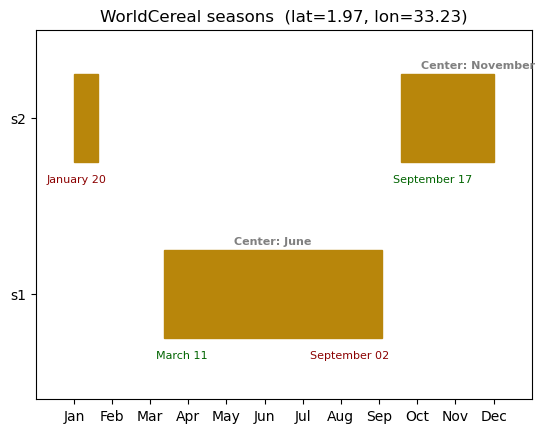

In [5]:
from notebook_utils.seasons import retrieve_worldcereal_seasons

spatial_extent = map.get_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Now let's also check the distribution of `validity_time` in your reference data.<br>
This attribute indicates the date for which the crop label is actually valid.<br>
This is important to consider when selecting your season of interest: it does not make too much sense to train a classifier for a season in which you have barely any valid reference data to work with!

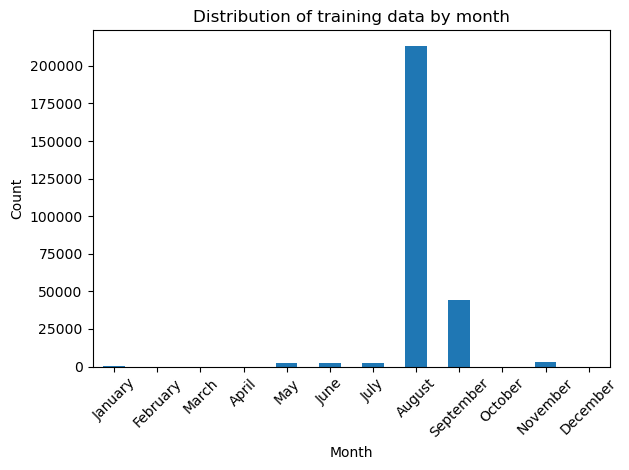

In [3]:
from notebook_utils.seasons import valid_time_distribution

valid_time_distribution(extractions)

Now use the slider to select your season of interest.<br>

Note that WorldCereal models are always trained on time series of **12 months**.<br>
Just make sure the center of your season of interest nicely coincides with the `Season center` as indicated below the slider.<br>

In [4]:
from notebook_utils.dateslider import season_slider

slider = season_slider()


In this step, our training data is first converted into a format which can be used by our training feature computation and model training routines.

Then, we filter out any sample for which the observation date (attribute `valid_time`) does not match the selected season of interest.

In [ ]:
from worldcereal.utils.refdata import process_extractions_df

# Retrieve the date range you just selected
season = slider.get_selected_dates()

# Process the merged data
training_df = process_extractions_df(extractions, season)

# Report on the contents of the data
print(f'Samples originating from {training_df["ref_id"].nunique()} unique reference datasets.')
print('Distribution of samples across years:')
print(training_df.year.value_counts())
ncroptypes = training_df['ewoc_code'].nunique()
print(f'Number of crop types remaining: {ncroptypes}')
if ncroptypes <= 1:
    raise ValueError("Not enough crop types found in the remaining data to train a model, cannot continue.")
training_df.head()

**Step 5: Select your crops of interest**

The following widget will display all available land cover classes and crop types in your training dataframe.

Tick the checkbox for each crop type you wish to explicitly include in your model.<br>
In case you wish to group multiple crops together, just tick the parent node in the hierarchy.

Non-selected crops will be merged together in an `other` class.

After selecting all your crop types of interest, hit the "Apply" button.

<div class="alert alert-block alert-info">
<b>Minimum number of samples:</b><br>
In order to train a model, we recommend a minimum of 30 samples to be available for each unique crop type.<br>
Any crop type in the dataframe with fewer than 30 samples will initially not be shown.<br>
You can adjust this threshold through the count_threshold parameter.
</div>


In [ ]:
from notebook_utils.croptypepicker import CropTypePicker

croptypepicker = CropTypePicker(sample_df=training_df, count_threshold=30, expand=True)

In the next cell, we apply your selection to your training dataframe.<br>
The new dataframe will contain a `downstream_class` attribute, denoting the final label.<br>
Let's first check which classes ended up in the "other" class:

In [ ]:
from notebook_utils.croptypepicker import apply_croptypepicker_to_df
from worldcereal.utils.legend import translate_ewoc_codes

training_df = apply_croptypepicker_to_df(training_df, croptypepicker)
other_count = training_df.loc[training_df['downstream_class'] == 'other']['ewoc_code'].value_counts()
other_labels = translate_ewoc_codes(other_count.index.tolist())
other_count.to_frame().merge(other_labels, left_index=True, right_index=True)

Based on this list, you might consider dropping some classes.<br>
This can be done by providing the "ewoc_codes" in the following cell:

In [ ]:
# drop classes
# to_drop = [1107000020, 1107000000, ]
to_drop = []
if len(to_drop) > 0:
    training_df = training_df.loc[~training_df['ewoc_code'].isin(to_drop)]
training_df['downstream_class'].value_counts()

Finally, you could opt to combine some classes using the code snippet below as an example:

In [ ]:
# combine_classes = {
#     'cereals': ['winter_barley', 'oats', 'millet', 'winter_rye', 'wheat']}
combine_classes = {}
for new_class, old_classes in combine_classes.items():
    training_df.loc[training_df['downstream_class'].isin(old_classes), 'downstream_class'] = new_class

# Report on the contents of the data
training_df['downstream_class'].value_counts()

**Step 6: Save your final training dataframe for future reference**

Upon executing the next cell, you will be prompted to provide a unique name for your dataframe.

In [ ]:
from pathlib import Path
from notebook_utils.classifier import get_input

df_name = get_input("Name dataframe")

training_dir = Path('./training_data')
training_dir.mkdir(exist_ok=True)

outfile = training_dir / f'{df_name}.csv'

if outfile.exists():
    raise ValueError(f"File {outfile} already exists. Please delete it or choose a different name.")

training_df.to_csv(outfile)

print(f"Dataframe saved to {outfile}")
training_df.head()

### 2. Prepare training features

Using a deep learning framework (Presto), we derive classification features for each sample in the dataframe resulting from your query. Presto was pre-trained on millions of unlabeled samples around the world and finetuned on global labelled land cover and crop type data from the WorldCereal reference database. The resulting *embeddings* (`presto_ft_0` -> `presto_ft_127`) and the target labels (`downstream_class`) to train on will be returned as a training dataframe which we will use for downstream model training.

We provide several options for users seeking to increase model robustness. By default, these options are disabled, but especially when training a model across multiple years in areas with much reference data, these options are worth considering:<rb>
- `augment` parameter: when set to `True` introduces slight temporal jittering of the processing window, making the model more robust against slight variations in seasonality across different years.
- `mask_ratio` parameter: value between zero and one. When larger than zero, random inputs are masked prior to embedding computation. This can be used to make the model more resilient against missing data (e.g. due to Sentinel-1 data being unavailable).


In [ ]:
from notebook_utils.classifier import prepare_training_dataframe

training_dataframe = prepare_training_dataframe(training_df, augment=False, mask_ratio=0)
training_dataframe.head()

### 3. Train custom classification model

We train a catboost model for the selected crop types.<br> 

By default, we apply **class balancing** to ensure minority classes are not discarded. However, depending on the class distribution this may lead to undesired results. There is no golden rule here. If your main goal is to make sure the most dominant classes in your training data are very precisely identified in your map, you can opt to NOT apply class balancing by setting: `balance_classes=False`. 

Before training, the available training data has been automatically split into a calibration and validation part. The validation report and confusion matrix already provide you with a first idea on your model's performance.<br>
For visualizing the confusion matrix, you have several options through the `show_confusion_matrix` parameter:
- `absolute`: print absolute sample counts in the confusion matrix
- `relative`: plots the normalized confusion matrix
- `none`: do not visualize a confusion matrix

In [ ]:
from notebook_utils.classifier import train_classifier

custom_model, report, confusion_matrix = train_classifier(
    training_dataframe, balance_classes=True, show_confusion_matrix='absolute',
)
print(report)

### 4. Deploy your custom model

Once trained, your model is uploaded to a dedicated S3 bucket on CDSE, so it can be accessed by OpenEO for generating maps (see next step).<br>
Your model is protected using your CDSE credentials and will not be accessible by anyone else.

Upon executing the next cell, you will be prompted to provide a clear and short name for your custom model.

Note that your model is only kept in cloud storage for a limited amount of time. <br>
Make sure to download your model (using the link provided) if you wish to store it for a longer period of time!<br>
In case you would like to use your model for generating maps at a later point in time, you will need to host your model in a publicly available repository, e.g. Google Drive, and replace `model_url` with this public link during model inference.

In [ ]:
from worldcereal.utils.upload import deploy_model
from openeo_gfmap.backend import cdse_connection
from notebook_utils.classifier import get_input

modelname = get_input("model")
model_url = deploy_model(cdse_connection(), custom_model, pattern=modelname)
print(f"Your model can be downloaded from: {model_url}")

### 5. Generate your custom crop type map

Using your custom model, we generate a map for your region and season of interest.

**Step 1: Select your area of interest (AOI)**

Provide a bounding box specifying the region for which you would like to create your map.<br>

<div class="alert alert-block alert-warning">
<b>Processing area:</b><br> 
The WorldCereal system is currently optimized to process <b>20 x 20 km</b> tiles.<br>
In case your AOI exceeds this area, it will be automatically split, creating multiple map generation jobs.

We ALWAYS recommend you to select a small area to start with, whenever trying out a model for the first time!

A run of 400 km² will typically consume 40 credits and last around 20 mins.<br>
</div>

We refer to [Section 1 of this notebook](###-1.-Gather-and-prepare-your-training-data) for instructions on how to use our interactive application.

In [ ]:
from worldcereal.utils.map import ui_map

map = ui_map(area_limit=1200) # area_limit in km²

Optionally save your drawn bounding box to a file for future reference:

In [ ]:
from notebook_utils.production import bbox_extent_to_gdf
from pathlib import Path

bbox_name = input('Enter the name for the output bbox file (without extension): ')
outfile = Path(f'./bbox/{bbox_name}.gpkg')
processing_extent = map.get_extent(projection='latlon')
bbox_extent_to_gdf(processing_extent, outfile)

**Step 2: Select your year and season of interest**

We always recommend to select a similar growing season as compared to the season for which you trained your model.<br>
In case your training data was restricted to 1 or 2 years, applying your model to other years will likely result in lower quality maps.

In [ ]:
from notebook_utils.dateslider import date_slider

processing_slider = date_slider()

**Step 3: Set processing parameters**

In [ ]:
# Do you want to automatically mask temporary crops using the default WorldCereal temporary crops mask?
# By default we do not mask temporary crops.
mask_cropland = False

# In case you set mask_cropland to True, choose whether you want to store the cropland mask as separate output
save_mask = False

# Choose whether or not you want to spatially clean the classification results
postprocess_result = True

# Choose the postprocessing method you want to use ["smooth_probabilities", "majority_vote"]
# ("smooth_probabilities will do limited spatial cleaning,
# while "majority_vote" will do more aggressive spatial cleaning, depending on the value of kernel_size)
postprocess_method = "majority_vote"

# Additional parameter for the majority vote method
# (the higher the value, the more aggressive the spatial cleaning,
# should be an odd number, not larger than 25, default = 5)
kernel_size = 5

# Do you want to save the intermediate results? (before applying the postprocessing)
save_intermediate = True

# Do you want to save all class probabilities in the final product?
# If set to False, you will only get the final classification label and confidence of the winning class per pixel
keep_class_probs = True

**Step 4: Start map production**

The next cell takes care of splitting your area of interest into small tiles (size is specified through `tile_resolution` parameter) and generate a map for each tile.<br>

You will be able to track progress through the automated reporting.<br>

Results will be automatically saved to a folder containing your model name:<br> `runs/CROPTYPE_custom_{your_modelname}_{timestamp}`<br>

The first time you run this, you will be asked to authenticate with your CDSE account by clicking the link provided below the cell.<br>

<div class="alert alert-block alert-warning">
<b>What to do in case of interruption?</b><br> 
In case processing got interrupted, just make sure to manually set `output_dir` to the directory you previously used. In this case, processing will just continue where it stopped.
</div>

In [ ]:
import pandas as pd
from pathlib import Path
from worldcereal.job import PostprocessParameters
from worldcereal.job import WorldCerealProductType, CropTypeParameters
from notebook_utils.production import start_production_process, monitor_production_process

# The output directory is named after the model
timestamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
output_dir = Path('./runs') / f'CROPTYPE_custom_{modelname}_{timestamp}'
print(f"Output directory: {output_dir}")

# Get all postprocessing parameters
postprocess_parameters = PostprocessParameters(
    enable=postprocess_result,
    method=postprocess_method,
    kernel_size=kernel_size,
    save_intermediate=save_intermediate,
    keep_class_probs=keep_class_probs,
)

# Initializes default parameters
parameters = CropTypeParameters()

# Update parameters with user-defined values
parameters.classifier_parameters.classifier_url = model_url
parameters.save_mask = save_mask
parameters.mask_cropland = mask_cropland

# Get processing period and area
processing_period = processing_slider.get_selected_dates()
processing_extent = map.get_extent(projection='latlon')
tile_resolution = 20   # in km

# job_options={"image-name":"registry.prod.warsaw.openeo.dataspace.copernicus.eu/prod/openeo-geotrellis-kube-python311:20250619-34"}

args = (processing_extent, processing_period, output_dir)
kwargs = dict(
    tile_resolution=tile_resolution,
    product_type=WorldCerealProductType.CROPTYPE,
    croptype_parameters=parameters,
    postprocess_parameters=postprocess_parameters,
    # job_options=job_options,
)

proc, queue, stop_event = start_production_process(args, kwargs)
status_df = monitor_production_process(proc, queue, stop_event)

**Step 5: Create merged product**

Once production across your tiles is finalized, you can use the cell below to merge the different tiles together into one map.<br>

In [ ]:
from notebook_utils.production import merge_maps

merged_path = merge_maps(output_dir, product='croptype')
print(f"Results merged to {merged_path}")

**Step 6: Inspect your map**

Up to four products are generated:
- `croptype-raw` --> your custom crop type product
- `croptype` --> your custom crop type product after post-processing
- `cropland-raw` --> cropland mask produced using the global WorldCereal cropland model
- `cropland` --> cropland mask, after post-processing

For each of these products, you will get a raster file containing at least two bands:
1. The label of the winning class
2. The probability of the winning class [50 - 100]
3. and beyond (optional, depending on settings): Class probabilities of each class

You can use the next cell to quickly visualize your crop type product in this notebook.

In case you want to compare all products, we recommend you to use QGIS.

In [ ]:
from notebook_utils.visualization import visualize_product
from worldcereal.utils.models import load_model_lut

lut = load_model_lut(model_url)
visualize_product(merged_path, product='croptype', lut=lut, write=True)


Congratulations, you have reached the end of this demo!